#### Objectives (analytical session)
 1. Build a Finesse model of a simple Michelson interferometer.
 1. Verify the DC" analysis results derived in the analytic calculations.
 1. Compute the transmission of the Michelson when the incident field has multiple spectral components.

In [2]:
from pykat import finesse        # import the whole pykat.finesse package
from pykat.commands import *     # import all packages in pykat.commands
import numpy as np               # for basic math/sci/array functions
import matplotlib.pyplot as plt  # for plotting
from matplotlib.ticker import FormatStrFormatter

# tell the notebook to automatically show plots inline below each cell
%matplotlib inline               
# use pykat's plotting style. change dpi to change plot sizes on your screen
pykat.init_pykat_plotting(dpi=90,fmts=['png'])

                                              ..-
    PyKat develop         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



## The Michelson Interferometer
First let's construct a basic model to review some simple behaviours of Michelson Interferometers

<div style="background-color:#cceffc;padding:10px;">

### Task 1: Simple Michelson

Create a `kat` object and parse the Finesse code to model the optical system depicted:
<img src="http://www.gwoptics.org/learn/schools/St_Andrews_2017/michelson_with_nodes.svg" width=40%>

Set the length of the Michelson's 'arms' to 1m and the mirror parameters of ETMx and ETMy to be R=1, T=0
</div>


In [25]:
base = finesse.kat()
base.verbose = False

Mich = """
l laser1 1.0 0 n1 # laser with P = 1W at the default frequency
s s1 0 n1 n2      # space connecting the laser to something
bs bs1 0.5 0.5 0 0 n2 n3 n4 n5 # 50:50 beam splitter
s Lx 1 n4 n8
s Ly 1 n3 n6
m ETMy 1 0 0 n6 n7
m ETMx 1 0 0 n8 n9 
pd pow_out n5
pd pow_refl n2
"""
base.parse(Mich)

<div style="background-color:#cceffc;padding:10px;">

### Task 2: Michelson response to microscopic length changes

1. Create a copy of your base `kat` object and output the power transmitted as the microscopic tuning of ETMx is varied from 0 to 180 degrees. 


2. Set the tuning of bs1 so that the transmitted power is zero when ETMx has a microscopic tuning of zero. This is often referred to as setting the interferometer to a 'dark fringe'. **Hint:** you can set the tuning of an optic using `kat.bs1.phi=...`

    <span style="color:green"> Note that in this answer notebook, we have set the "Angle-of-Incidence" of the beamsplitter to the unphysical value of 0 degrees. From a nodal connections point of view, this is inconsequential. However, the beamsplitter tuning is always applied in a direction that is *normal* to the beam-splitter's surface. You can find the mathematical description of this phenomenon in Eqs. 3.47-3.48 of the [Finesse Manual](http://www.gwoptics.org/finesse/download/manual.pdf). </span>


3. Produce the output again for the adjusted setup, and plot the results of both simulations on the same figure.

Where has the power gone, if it is not detected at `n5` (aka the 'asymmetric port')?

</div>

In [1]:
kat = base.deepcopy()
kat.parse("xaxis ETMx phi lin 0 180 200")
out1=kat.run()


#the difference between the phase of the two fields when they recombine at bs1 should be 180deg.
#we get a factor 2 from travelling each direction in each arm
#and by tuning the bs, we apply +45deg to one arm and -45deg to the other.
# kat.bs1.phi=45
kat.ETMy.phi = 90
out2 = kat.run()

plt.figure()
plt.plot(out1.x,out1['pow_out'],label='original')
plt.plot(out2.x,out2['pow_out'],label='dark fringe')
plt.plot(out2.x,out2['pow_refl'],label='pow_refl',ls=':')
plt.xlabel('ETMx tuning [deg]')
plt.ylabel('power out [W]')
plt.legend(loc=5)

#Since both end mirrors have R=1, all of the power not seen at 
#the asymmetric port must be reflected back towards the laser.
#you can check this by adding a pd at n2, aka the 'symmetric port'

NameError: name 'base' is not defined

<div style="background-color:#cceffc;padding:10px;">

### Task 3: Michelson response to 'Common' and 'Differential' length changes

Starting from your 'dark fringe' Michelson model, add another `pd` to monitor the power at `n2`, and include a `put` command to simulate two cases:

1. ETMy always has the *same* microscopic detuning as ETMx - a 'Common' change
2. ETMy always has the *opposite* microscopic detuning to ETMy - a 'Differential' change

Why does this happen? Why is this an advantage for gravitational-wave detectors?

</div>

You may find it helpful to refer to the Finesse <a href="http://www.gwoptics.org/finesse/reference/">Syntax reference</a>.

**Hint:** The variable `$x1` is the current value of the `xaxis` parameter. The variable `$mx1` is the *negative* of the current `xaxis` value.

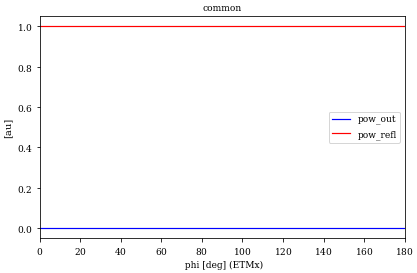

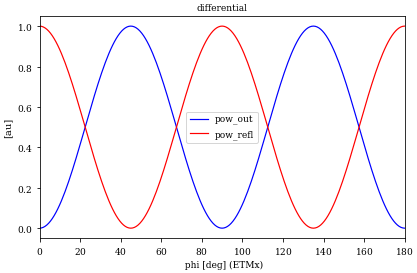

In [27]:
kat = base.deepcopy()
#setting to a dark fringe
kat.bs1.phi = 45
#adding the new detector and xaxis that'll be used in both simulations
kat.parse("""
pd pow_refl n2
xaxis ETMx phi lin 0 180 200
""")

#common arm tuning changes
katC = kat.deepcopy()
katC.parse("""
put ETMy phi $x1
""")
out=katC.run()
out.plot(title='common')

#differential arm tuning changes
katC = kat.deepcopy()
katC.parse("""
put ETMy phi $mx1
""")
out=katC.run()
out.plot(title='differential')

#the Michelson is naturally insensitive to effects that are common to both arms
#this is an advantage for gravitational wave detection, as noise sources that 
#affect both arms in common don't reach the 'asymmetric' port where we make the detection.